OpenMC's general tally system accommodates a wide range of tally *filters*. While most filters are meant to identify regions of phase space that contribute to a tally, there are a special set of functional expansion filters that will multiply the tally by a set of orthogonal functions, e.g. Legendre polynomials, so that continuous functions of space or angle can be reconstructed from the tallied moments.

In this example, we will determine the spatial dependence of the flux along the $z$ axis by making a Legendre polynomial expansion. Let us represent the flux along the z axis, $\phi(z)$, by the function

$$ \phi(z') = \sum\limits_{n=0}^N a_n P_n(z') $$

where $z'$ is the position normalized to the range [-1, 1]. Since $P_n(z')$ are known functions, our only task is to determine the expansion coefficients, $a_n$. By the orthogonality properties of the Legendre polynomials, one can deduce that the coefficients, $a_n$, are given by

$$ a_n = \frac{2n + 1}{2} \int_{-1}^1 dz' P_n(z') \phi(z').$$

Thus, the problem reduces to finding the integral of the flux times each Legendre polynomial -- a problem which can be solved by using a Monte Carlo tally. By using a Legendre polynomial filter, we obtain stochastic estimates of these integrals for each polynomial order.

In [1]:
%matplotlib inline
import openmc
import numpy as np
import matplotlib.pyplot as plt

To begin, let us first create a simple model. The model will be a slab of fuel material with reflective boundaries conditions in the x- and y-directions and vacuum boundaries in the z-direction. However, to make the distribution slightly more interesting, we'll put some B<sub>4</sub>C in the middle of the slab.

In [2]:
# Define fuel and B4C materials
fuel = openmc.Material()
fuel.add_element('U', 1.0, enrichment=4.5)
fuel.add_nuclide('O16', 2.0)
fuel.set_density('g/cm3', 10.0)

b4c = openmc.Material()
b4c.add_element('B', 4.0)
b4c.add_nuclide('C0', 1.0)
b4c.set_density('g/cm3', 2.5)

In [3]:
# Define surfaces used to construct regions
zmin, zmax = -10., 10.
box = openmc.model.get_rectangular_prism(10., 10., boundary_type='reflective')
bottom = openmc.ZPlane(z0=zmin, boundary_type='vacuum')
boron_lower = openmc.ZPlane(z0=-0.5)
boron_upper = openmc.ZPlane(z0=0.5)
top = openmc.ZPlane(z0=zmax, boundary_type='vacuum')

# Create three cells and add them to geometry
fuel1 = openmc.Cell(fill=fuel, region=box & +bottom & -boron_lower)
absorber = openmc.Cell(fill=b4c, region=box & +boron_lower & -boron_upper)
fuel2 = openmc.Cell(fill=fuel, region=box & +boron_upper & -top)
geom = openmc.Geometry([fuel1, absorber, fuel2])

For the starting source, we'll use a uniform distribution over the entire box geometry.

In [4]:
settings = openmc.Settings()
spatial_dist = openmc.stats.Box(*geom.bounding_box)
settings.source = openmc.Source(space=spatial_dist)
settings.batches = 210
settings.inactive = 10
settings.particles = 1000

Defining the tally is relatively straightforward. One simply needs to list 'flux' as a score and then add an expansion filter. For this case, we will want to use the `SpatialLegendreFilter` class which multiplies tally scores by Legendre polynomials evaluated on normalized spatial positions along an axis.

In [8]:
# Create a flux tally
flux_tally = openmc.Tally()
flux_tally.scores = ['flux']

# Create a Legendre polynomial expansion filter and add to tally
order = 8
expand_filter = openmc.ZernikeFilter(order)
flux_tally.filters.append(expand_filter)

The last thing we need to do is create a `Tallies` collection and export the entire model, which we'll do using the `Model` convenience class.

In [9]:
tallies = openmc.Tallies([flux_tally])
model = openmc.model.Model(geometry=geom, settings=settings, tallies=tallies)

In [11]:
model.export_to_xml()

Running a simulation is now as simple as calling the `run()` method of `Model`.

In [7]:
model.run(output=False)

0.30053345698336226+/-0.000642428544299398

Now that the run is finished, we need to load the results from the statepoint file.

In [8]:
with openmc.StatePoint('statepoint.210.h5') as sp:
    df = sp.tallies[flux_tally.id].get_pandas_dataframe()

We've used the `get_pandas_dataframe()` method that returns tally data as a Pandas dataframe. Let's see what the raw data looks like.

In [9]:
df

,spatiallegendre,nuclide,score,mean,std. dev.
0,P0,total,flux,36.434828,0.076755
1,P1,total,flux,0.021797,0.043545
2,P2,total,flux,-4.380892,0.025739
3,P3,total,flux,0.001448,0.020740
4,P4,total,flux,-0.295439,0.014215
5,P5,total,flux,0.003514,0.012017
6,P6,total,flux,0.105213,0.010103
7,P7,total,flux,0.002595,0.009265
8,P8,total,flux,-0.096197,0.007513


Since the expansion coefficients are given as

$$ a_n = \frac{2n + 1}{2} \int_{-1}^1 dz' P_n(z') \phi(z')$$

we just need to multiply the Legendre moments by $(2n + 1)/2$.

In [10]:
n = np.arange(order + 1)
a_n = (2*n + 1)/2 * df['mean']

To plot the flux distribution, we can use the `numpy.polynomial.Legendre` class which represents a truncated Legendre polynomial series. Since we really want to plot $\phi(z)$ and not $\phi(z')$ we first need to perform a change of variables. Since

$$ \lvert \phi(z) dz \rvert = \lvert \phi(z') dz' \rvert $$

and, for this case, $z = 10z'$, it follows that

$$ \phi(z) = \frac{\phi(z')}{10} = \sum_{n=0}^N \frac{a_n}{10} P_n(z'). $$

In [11]:
phi = np.polynomial.Legendre(a_n/10, domain=(zmin, zmax))

Let's plot it and see how our flux looks!

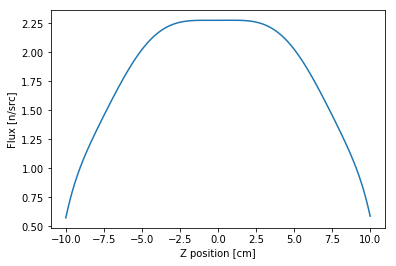

In [12]:
z = np.linspace(zmin, zmax, 1000)
plt.plot(z, phi(z))
plt.xlabel('Z position [cm]')
plt.ylabel('Flux [n/src]')

As you might expect, we get a rough cosine shape but with a flux depression in the middle due to the boron slab that we introduced. To get a more accurate distribution, we'd likely need to use a higher order expansion.

One more thing we can do is confirm that integrating the distribution gives us the same value as the first moment (since $P_0(z') = 1$). This can easily be done by numerically integrating using the trapezoidal rule:

In [13]:
np.trapz(phi(z), z)

36.434786672754925

In addition to being able to tally Legendre moments, there are also functional expansion filters available for spherical harmonics (`SphericalHarmonicsFilter`) and Zernike polynomials over a unit disk (`ZernikeFilter`). A separate `LegendreFilter` class can also be used for determining Legendre scattering moments (i.e., an expansion of the scattering cosine, $\mu$).

# Next task is to put in some absorbers and see whether I can get a Zernike flux shape that I like

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import openmc
from openmc.examples import pwr_pin_cell
import numpy as np
from series.Zernike import Zernike

model = openmc.model.Model()

# Define materials.
fuel = openmc.Material(name='UO2 (2.4%)')
fuel.set_density('g/cm3', 10.29769)
fuel.add_nuclide("U234", 4.4843e-6)
fuel.add_nuclide("U235", 5.5815e-4)
fuel.add_nuclide("U238", 2.2408e-2)
fuel.add_nuclide("O16", 4.5829e-2)

clad = openmc.Material(name='Zircaloy')
clad.set_density('g/cm3', 6.55)
clad.add_nuclide("Zr90", 2.1827e-2)
clad.add_nuclide("Zr91", 4.7600e-3)
clad.add_nuclide("Zr92", 7.2758e-3)
clad.add_nuclide("Zr94", 7.3734e-3)
clad.add_nuclide("Zr96", 1.1879e-3)

hot_water = openmc.Material(name='Hot borated water')
hot_water.set_density('g/cm3', 0.740582)
hot_water.add_nuclide("H1", 4.9457e-2)
hot_water.add_nuclide("O16", 2.4672e-2)
hot_water.add_nuclide("B10", 8.0042e-6)
hot_water.add_nuclide("B11", 3.2218e-5)
hot_water.add_s_alpha_beta('c_H_in_H2O')

b4c = openmc.Material()
b4c.add_element('B', 4.0)
b4c.add_nuclide('C0', 1.0)
b4c.set_density('g/cm3', 2.5)

# Define the materials file.
model.materials = (fuel, b4c, hot_water)

# Instantiate ZCylinder surfaces
pitch = 1.26
fuel_or = openmc.ZCylinder(x0=0, y0=0, R=0.39218, name='Fuel OR')
absorber_or = openmc.ZCylinder(x0=0, y0=0, R=0.45720, name='Absorber OR')
left = openmc.XPlane(x0=-pitch/2, name='left', boundary_type='reflective')
right = openmc.XPlane(x0=pitch/2, name='right', boundary_type='reflective')
bottom = openmc.YPlane(y0=-pitch/2, name='bottom',
                       boundary_type='reflective')
top = openmc.YPlane(y0=pitch/2, name='top', boundary_type='reflective')

# Instantiate Cells
fuel_pin = openmc.Cell(name='Fuel', fill=fuel)
absorber = openmc.Cell(name='Absorber', fill=b4c)
water = openmc.Cell(name='Water', fill=hot_water)

# Use surface half-spaces to define regions
fuel_pin.region = -fuel_or
absorber.region = +fuel_or & -absorber_or
water.region = +absorber_or & +left & -right & +bottom & -top

# Create root universe
model.geometry.root_universe = openmc.Universe(0, name='root universe')
model.geometry.root_universe.add_cells([fuel_pin, absorber, water])


model.settings.batches = 210
model.settings.inactive = 10
model.settings.particles = 1000

max_zernike_order = 10
flux_tallies = [openmc.Tally() for i in range(max_zernike_order, -1, -1)]
fission_tallies = [openmc.Tally() for i in range(max_zernike_order, -1, -1)]
zernike_filters = [openmc.ZernikeFilter(n, r=.63) for n in range(max_zernike_order, -1, -1)]

for fiss_tally,flux_tally,tfilter in zip(fission_tallies, 
                                         flux_tallies,
                                         zernike_filters):
    fiss_tally.scores = ['fission']
    flux_tally.scores = ['flux']
    fiss_tally.filters = [tfilter]
    flux_tally.filters = [tfilter]
    
mesh = openmc.Mesh()
mesh.dimension = [100, 100]
mesh.lower_left = [-0.63, -0.63]
mesh.upper_right = [0.63, 0.63]

# Create mesh filter for tally
mesh_filter = openmc.MeshFilter(mesh)

# Create mesh tally to score flux and fission rate
mesh_tally = openmc.Tally(name='mesh_flux')
mesh_tally.filters = [mesh_filter]
mesh_tally.scores = ['flux', 'fission']

model.tallies = flux_tallies + fission_tallies + [mesh_tally]

model.run(openmc_exec="/Users/lindad/projects/Okapi/openmc/build/bin/openmc")


                               %%%%%%%%%%%%%%%
                          %%%%%%%%%%%%%%%%%%%%%%%%
                       %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                     %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                   %%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                ###############      %%%%%%%%%%%%%%%%%%%%%%%%
               ##################     %%%%%%%%%%%%%%%%%%%%%%%
               ###################     %%%%%%%%%%%%%%%%%%%%%%%
               ####################     %%%%%%%%%%%%%%%%%%%%%%
               #####################     %%%%%%%%%%%%%%%%%%%%%
               ######################     %%%%%%%%%%%%%%%%%%%%
               #######################     %%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%

      119/1    0.13470    0.13192 +/- 0.00047
      120/1    0.13277    0.13193 +/- 0.00047
      121/1    0.13085    0.13192 +/- 0.00046
      122/1    0.12475    0.13186 +/- 0.00046
      123/1    0.13078    0.13185 +/- 0.00046
      124/1    0.13206    0.13185 +/- 0.00045
      125/1    0.12869    0.13182 +/- 0.00045
      126/1    0.12621    0.13177 +/- 0.00045
      127/1    0.13406    0.13179 +/- 0.00045
      128/1    0.13018    0.13178 +/- 0.00044
      129/1    0.12926    0.13176 +/- 0.00044
      130/1    0.13422    0.13178 +/- 0.00044
      131/1    0.13609    0.13181 +/- 0.00043
      132/1    0.12625    0.13177 +/- 0.00043
      133/1    0.12445    0.13171 +/- 0.00043
      134/1    0.13171    0.13171 +/- 0.00043
      135/1    0.12569    0.13166 +/- 0.00043
      136/1    0.13818    0.13171 +/- 0.00043
      137/1    0.13316    0.13172 +/- 0.00042
      138/1    0.12233    0.13165 +/- 0.00043
      139/1    0.12797    0.13162 +/- 0.00043
      140/1    0.13180    0.13162 

0.1314535410984748+/-0.00032365941403060045

In [2]:
with openmc.StatePoint('statepoint.210.h5') as sp:
    output_flux_tallies = [sp.tallies[ftally.id].get_pandas_dataframe() 
            for ftally in flux_tallies]
    output_fission_tallies = [sp.tallies[ftally.id].get_pandas_dataframe() 
                      for ftally in fission_tallies]
    output_mesh_tally = sp.get_tally(id=mesh_tally.id)

In [3]:
fission_mesh = output_mesh_tally.get_slice(scores=['fission'])
flux_mesh = output_mesh_tally.get_slice(scores=['flux'])

In [6]:
flux_mesh.mean.shape = (100, 100)
fission_mesh.mean.shape = (100, 100)

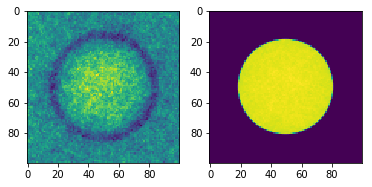

In [7]:
fig = plt.subplot(121)
fig.imshow(flux_mesh.mean)
fig2 = plt.subplot(122)
fig2.imshow(fission_mesh.mean)

In [8]:
flux_coeffs = [ftally['mean'] for ftally in output_flux_tallies]
fission_coeffs = [ftally['mean'] for ftally in output_fission_tallies]

In [9]:
flux_zernike_polys = [Zernike(order, 0, 0, .63) 
                         for order in range(max_zernike_order, -1, -1)]
fission_zernike_polys = [Zernike(order, 0, 0, .63) 
                         for order in range(max_zernike_order, -1, -1)]

for poly, coeffs in zip(fission_zernike_polys, fission_coeffs):
    poly.coefficients = coeffs
for poly, coeffs in zip(flux_zernike_polys, flux_coeffs):
    poly.coefficients = coeffs    

In [10]:
x = np.linspace(-.63, .63, 1000)

flux_evals = [np.zeros((x.size)) for poly in flux_zernike_polys]
fission_evals = [np.zeros((x.size)) for poly in fission_zernike_polys]

for index, xval in enumerate(x):
    for fission_eval, poly in zip(fission_evals, fission_zernike_polys):
        fission_eval[index] = poly(xval, 0)
    for flux_eval, poly in zip(flux_evals, flux_zernike_polys):
        flux_eval[index] = poly(xval, 0)

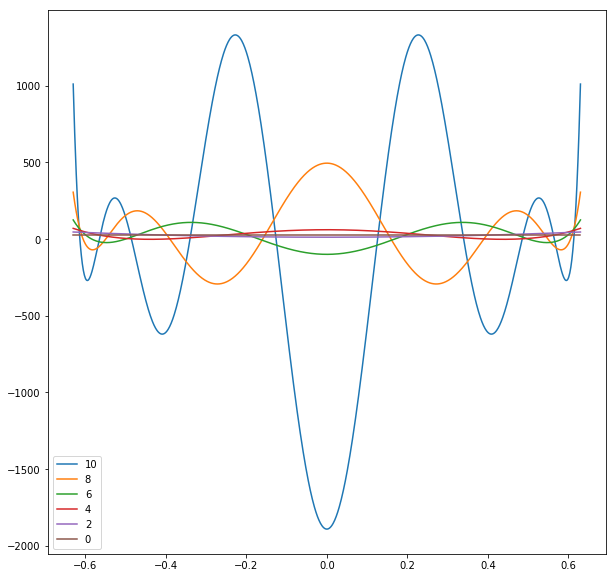

In [12]:
plt.rcParams['figure.figsize'] = [10, 10]

for i in range(10, -1, -2):
    plt.plot(x, flux_evals[max_zernike_order - i], label=str(i))
    plt.legend()

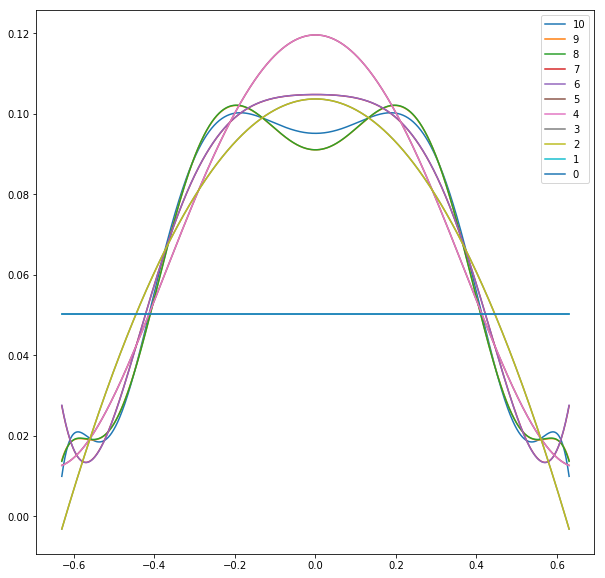

In [13]:
plt.rcParams['figure.figsize'] = [10, 10]

for i in range(10, -1, -1):
    plt.plot(x, fission_evals[max_zernike_order - i], label=str(i))
    plt.legend()

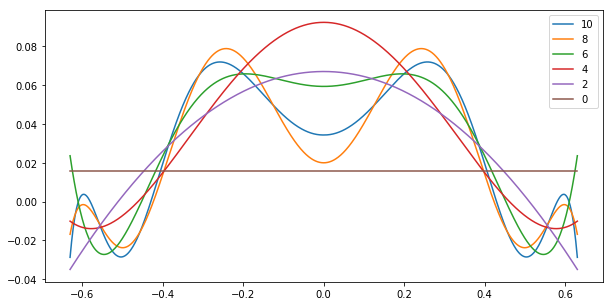

In [12]:
for i in range(max_zernike_order, -1, -2):
    plt.plot(x, fission_evals[max_zernike_order - i], label=str(i))
    plt.legend()

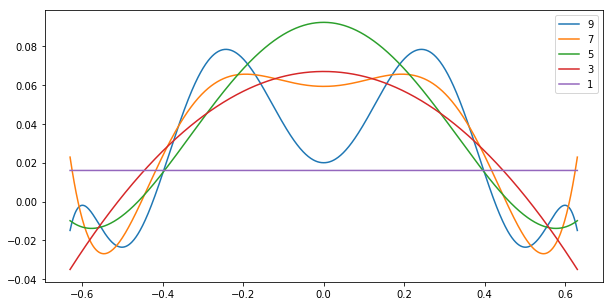

In [13]:
for i in range(max_zernike_order - 1, -1, -2):
    plt.plot(x, fission_evals[max_zernike_order - i], label=str(i))
    plt.legend()

In [8]:
def nonsmooth_fission_shape(r, phi):
    fuel_radius = 0.39218
    outer_radius = .63
    if r <= fuel_radius:
        return cos(r * pi / (2 * fuel_radius))
    else:
        return 0
    


In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
import openmc
from openmc.examples import pwr_pin_cell
import numpy as np
from series.Zernike import Zernike

from math import cos, pi

max_radius = .63

max_zernike_order = 10

fission_zernike_polys = [Zernike(order, 0, 0, max_radius) 
                         for order in range(max_zernike_order, -1, -1)]

import sympy as sp

def sp_fission_shape():
    phi = sp.symbols('phi')
    r = sp.symbols('r')
    return sp.cos(r * sp.pi / 2)

def advanced_fission_shape(r, phi):
    fuel_radius = 0.39218
    if r < fuel_radius:
        return cos(r * pi / (2 * fuel_radius))
    else:
        return 0
    
def fission_shape(r, phi):
    fuel_radius = max_radius
    return cos(r * pi / (2 * fuel_radius))

def linear(r, phi):
    return r

def sp_linear():
    r = sp.symbols('r')
    return r

def constant(r, phi):
    return 1

def sp_constant():
    return 1

model_function = advanced_fission_shape
model_sym_function = fission_shape

plot_intervals = 100
r_array = np.linspace(0, max_radius, 100)
true_soln = np.zeros((r_array.size))

In [20]:
for poly in fission_zernike_polys:
    poly.generateCoefficients(model_function, num_rintervals=100,
                             num_aintervals=20)
    
num_poly_evals = [np.zeros((r_array.size)) for poly in fission_zernike_polys]

for index,r in enumerate(r_array):
    for poly_eval, poly in zip(num_poly_evals, fission_zernike_polys):
        poly_eval[index] = poly(r, 0)
    true_soln[index] = model_function(r, 0)

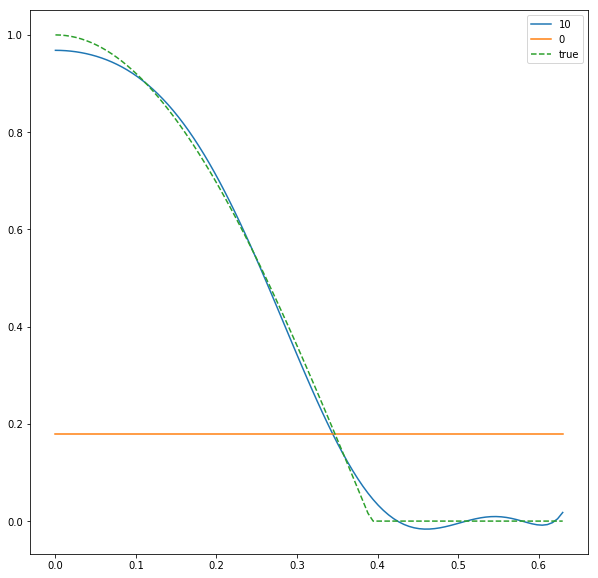

In [23]:
plt.rcParams['figure.figsize'] = [10, 10]

for i in range(10, -1, -10):
    plt.plot(r_array, num_poly_evals[max_zernike_order-i], label=str(i))
plt.plot(r_array, true_soln, '--', label='true')
plt.legend() 

In [10]:
for poly in fission_zernike_polys:
    poly.symbolicCoefficients(model_sym_function())

poly_evals = [np.zeros((r_array.size)) for poly in fission_zernike_polys]

for index,r in enumerate(r_array):
    for poly_eval, poly in zip(poly_evals, fission_zernike_polys):
        poly_eval[index] = poly.symbolicEval(r, 0)
    true_soln[index] = model_function(r, 0)

(0.98, 1.02)

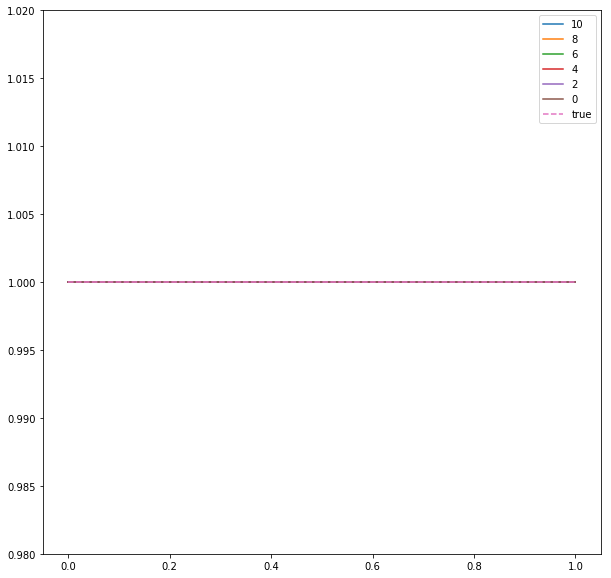

In [20]:
plt.rcParams['figure.figsize'] = [10, 10]

for i in range(max_zernike_order, -1, -2):
    plt.plot(r_array, poly_evals[max_zernike_order-i], label=str(i))
plt.plot(r_array, true_soln, '--', label='true')
plt.legend()
plt.ylim(.98, 1.02)

In [32]:
def trap_integrate_cylindrical(num_rintervals, num_aintervals, function):
    integral = 0
    dr = 1 / num_rintervals
    dphi = 2 * pi / num_aintervals
    num_rpoints = num_rintervals + 1
    num_apoints = num_aintervals + 1
    for i in range(num_rpoints):
        for j in range(num_apoints):
            w = 1
            if i == 0 or i == num_rpoints - 1:
                w *= .5
            if j == 0 or j == num_apoints - 1:
                w *= .5
            integral += w * function(i * dr, j * dphi) * i * dr * dr * dphi
    return 1 / pi * integral

In [17]:
def test(r):
    return r

In [34]:
trap_integrate_cylindrical(1, 1, constant)

1.0

In [20]:
trap_integrate_cylindrical(10, test)

0.3350000000000001